In [97]:
# Successfully installed missingno-0.5.2
# Successfully installed wordcloud-1.9.2
# !pip install missingno
# !pip install wordcloud

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno

from collections import Counter
import collections
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings('ignore')

#### Dataset: https://www.kaggle.com/datasets/shivamb/netflix-shows

In [122]:
df = pd.read_csv('netflix_titles.csv')

In [123]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [124]:
df.shape

(8807, 12)

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [126]:
print("Missing Values in each column:")
df.isnull().sum()

Missing Values in each column:


show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

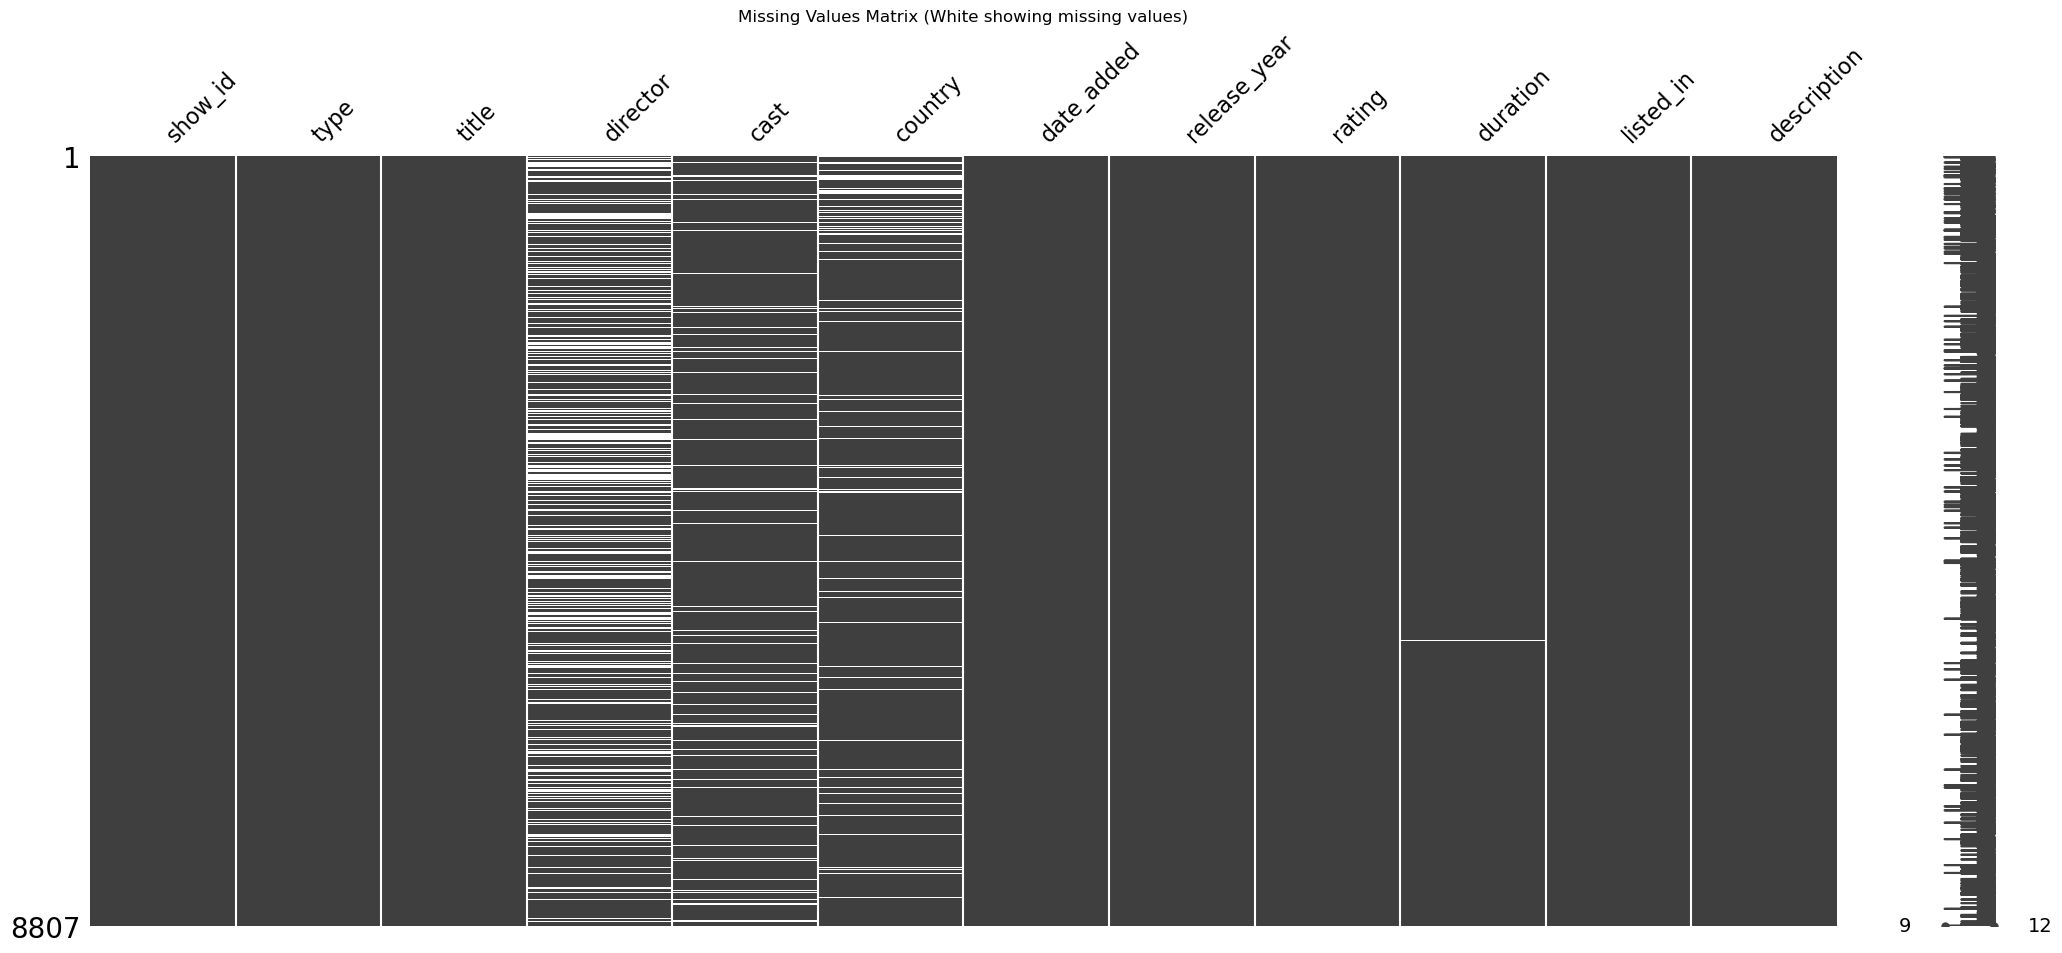

In [127]:
msno.matrix(df)

plt.title('Missing Values Matrix (White showing missing values)')
plt.show()

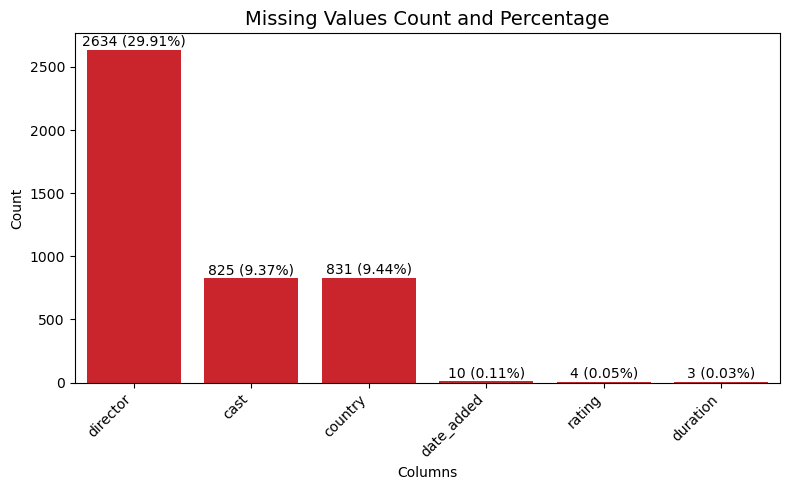

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_missing_values(df, columns):
    missing_data = df[columns].isnull().sum()
    total_rows = len(df)
    missing_pct = (missing_data / total_rows) * 100

    missing_info = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage': missing_pct})

    plt.figure(figsize=(8, 5))
    sns.barplot(x=missing_info.index, y='Missing Count', data=missing_info, color='#E50914')
    plt.title('Missing Values Count and Percentage', size=14)
    plt.xlabel('Columns')
    plt.ylabel('Count')

    for i, count in enumerate(missing_info['Missing Count']):
        percent = missing_info['Missing Percentage'][i]
        label = f'{count} ({percent:.2f}%)' 
        plt.text(i, count + 10, label, ha='center', va='bottom', fontsize=10, color='black')

    plt.xticks(range(len(columns)), columns, rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(False)
    plt.show()

columns_with_missing_values = df.columns[df.isnull().any()].tolist()
plot_missing_values(df, columns_with_missing_values)


Removing missing values for date_added, rating, and duration since they only contain a small number of missing values, hence, they do not have much impact on data.

In [129]:
df = df.dropna(subset = ['date_added', 'rating', 'duration'])

For missing values in director, country and cast, we will replace them with "Unknown"

In [130]:
cols_impute = ['director', 'country', 'cast']
for column in cols_impute:
    df[column].fillna("Unknown", inplace=True)

In [131]:
# Checking again to see if any null values are present
df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [132]:
df[['month_added', 'day_added', 'year_added']] = df['date_added'].str.strip().str.split(' ', expand=True)
df['year_added'] = df['year_added'].astype('int64')

# Remove commas from day_added
df['day_added'] = df['day_added'].str.split(',').str[0].str.replace(',', '')

# Parse 'date_added' column with a flexible date format
df['date_added'] = pd.to_datetime(df['date_added'], format='%B %d, %Y', errors='coerce')

# Create a day_of_week column
df['day_of_week'] = df['date_added'].dt.day_name()

month_to_quarter = {
    'January': 'Q1',
    'February': 'Q1',
    'March': 'Q1',
    'April': 'Q2',
    'May': 'Q2',
    'June': 'Q2',
    'July': 'Q3',
    'August': 'Q3',
    'September': 'Q3',
    'October': 'Q4',
    'November': 'Q4',
    'December': 'Q4'
}

df['quarter'] = df['month_added'].map(month_to_quarter)

## Exploratory Data Analysis (EDA)

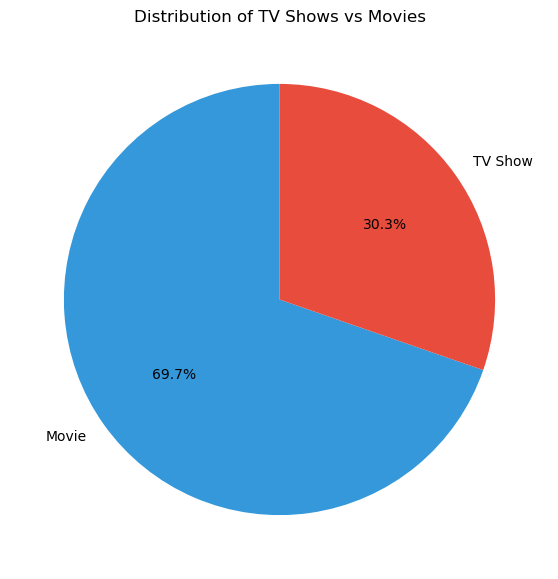

In [133]:
type_counts = df['type'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=90)

plt.title('Distribution of TV Shows vs Movies')

plt.show()

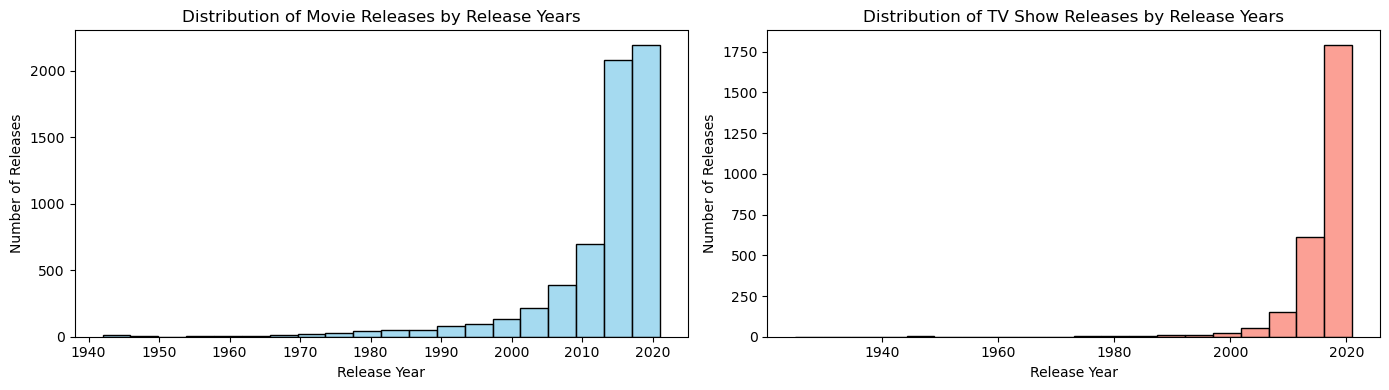

In [134]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
sns.histplot(data=df[df['type'] == 'Movie'], x='release_year', bins=20, color='skyblue')
plt.title('Distribution of Movie Releases by Release Years')
plt.xlabel('Release Year')
plt.ylabel('Number of Releases')

plt.subplot(1, 2, 2)
sns.histplot(data=df[df['type'] == 'TV Show'], x='release_year', bins=20, color='salmon')
plt.title('Distribution of TV Show Releases by Release Years')
plt.xlabel('Release Year')
plt.ylabel('Number of Releases')

plt.tight_layout()

plt.show()

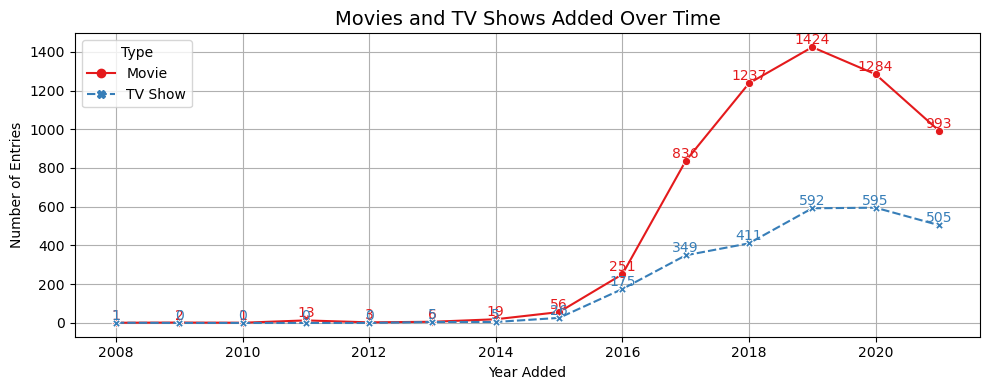

In [135]:
count_by_type_year = df.groupby(['year_added', 'type']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 4))

colors = sns.color_palette("Set1", n_colors=len(count_by_type_year.columns))

sns.lineplot(data=count_by_type_year, markers=True, palette=colors)

for col in count_by_type_year.columns:
    for year, count in zip(count_by_type_year.index, count_by_type_year[col]):
        plt.text(year, count, str(count), ha='center', va='bottom', fontsize=10, color=colors[count_by_type_year.columns.to_list().index(col)])

plt.title('Movies and TV Shows Added Over Time', size=14)
plt.xlabel('Year Added')
plt.ylabel('Number of Entries')
plt.legend(title='Type')

plt.grid(True)
plt.tight_layout()
plt.show()

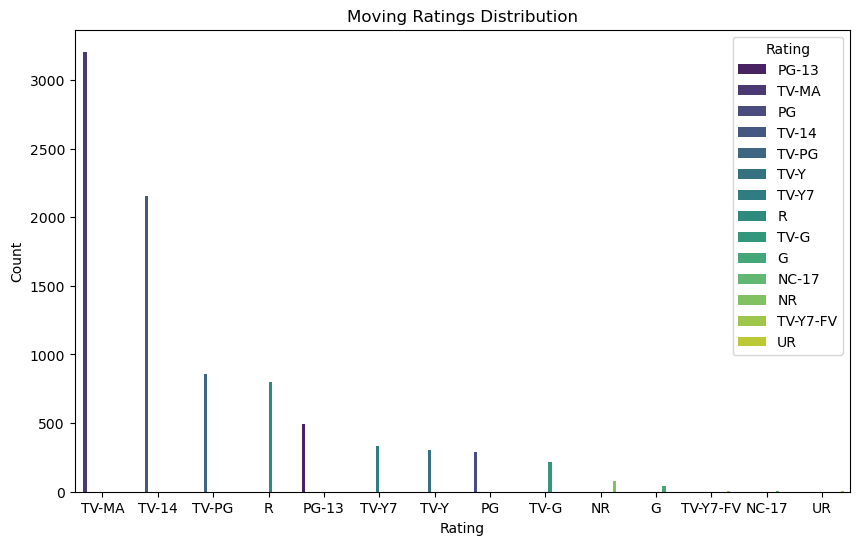

In [136]:
rating_counts = df['rating'].value_counts().sort_values(ascending=False).index

# Create a histogram using Seaborn countplot with ordered ratings
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='rating', hue='rating', palette='viridis', order=rating_counts, linewidth=10)

# Customize the chart
plt.title('Moving Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(title='Rating', loc='upper right')

# Show the plot
plt.show()

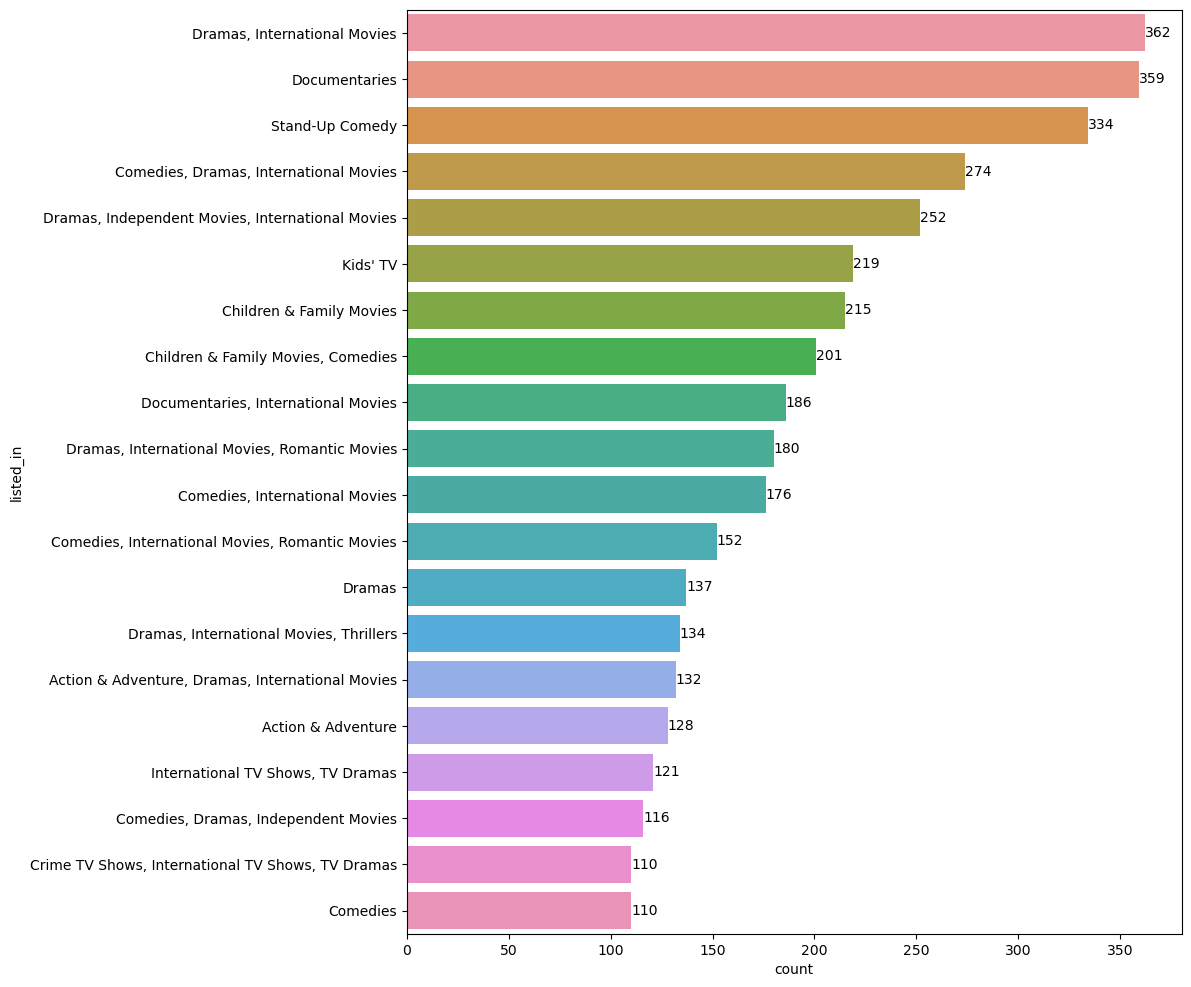

In [137]:
plt.figure(figsize=(10, 12))
ax = sns.countplot(data=df, y="listed_in", order=df['listed_in'].value_counts().index[0:20])
ax.bar_label(ax.containers[0])
plt.show()

In [151]:
df['genres'] = df['listed_in'].str.split(', ')

df_exploded = df.explode('genres')


fig = px.sunburst(df_exploded, path=['type', 'genres'], 
                  title='Most Genres in Netflix Breakdown by Type (Movie vs. TV Show)',
                  color_discrete_sequence=px.colors.qualitative.Set2)


fig.update_layout(width=800, height=600)
fig.show(renderer="iframe")

In [168]:
df9=df['listed_in'].str.split(',')
df9
list9=np.concatenate(df9.values)
ar9=np.array(list9)
ar9
dict9=collections.Counter(ar9)
dict9_key=list(dict9.keys())
dict9_val=list(dict9.values())
dict9_val_arg=np.argsort(dict9_val)
dict9_sorted = {dict9_key[i]:dict9_val[i] for i in dict9_val_arg}
df10=pd.DataFrame.from_dict(dict9_sorted, orient='index', columns=['Count']).reset_index().sort_values(by='Count', ascending=False).head(10)
df10=df10.rename(columns={'index':'listed_in'})

fig=px.treemap(df10, path=['listed_in'], values='Count')
fig.show(renderer="iframe")

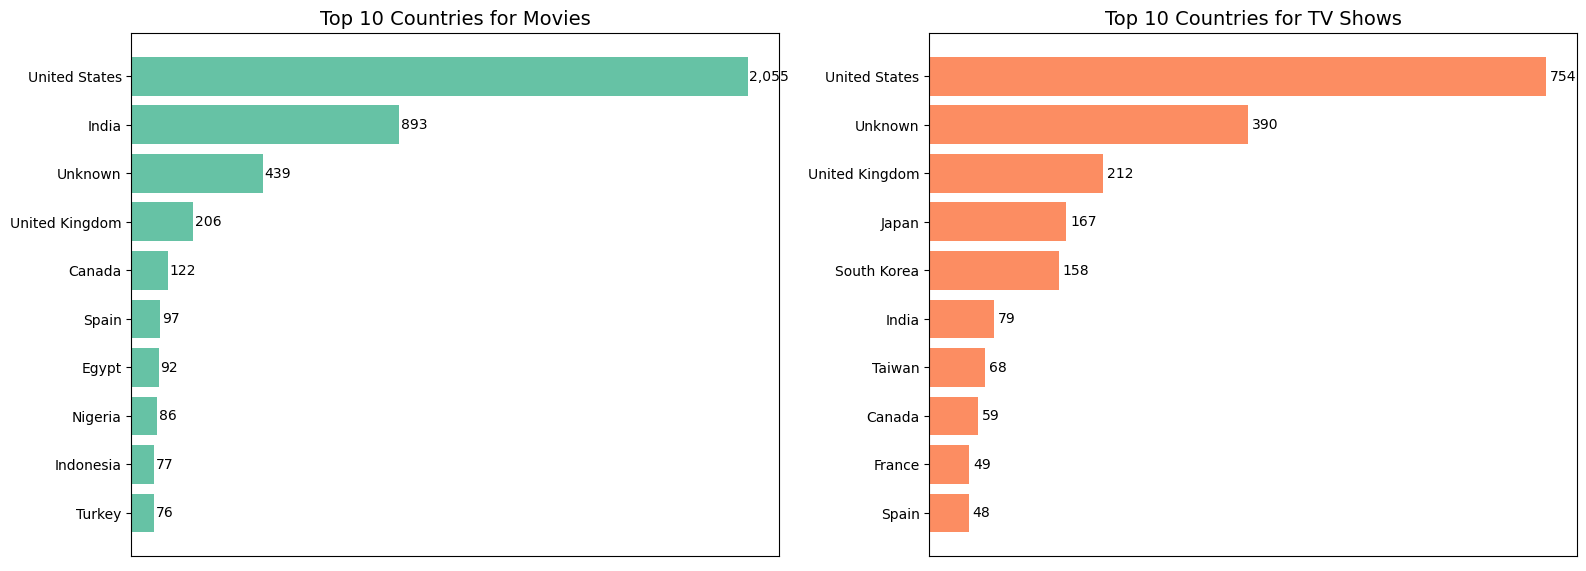

In [153]:
# Count occurrences of each country for movies
movie_counts = df[df['type'] == 'Movie']['country'].value_counts().head(10)

# Count occurrences of each country for TV shows
tv_show_counts = df[df['type'] == 'TV Show']['country'].value_counts().head(10)

# Sort movie counts in descending order
movie_counts = movie_counts.sort_values(ascending=False)

colors = sns.color_palette("Set2")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(movie_counts.index, movie_counts.values, color=colors[0])
for i, v in enumerate(movie_counts.values):
    axes[0].text(v + 5, i, f'{v:,}', va='center', fontsize=10)

axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_title('Top 10 Countries for Movies', size = 14)
axes[0].invert_yaxis() 
# TV Shows chart
axes[1].barh(tv_show_counts.index, tv_show_counts.values, color=colors[1])
for i, v in enumerate(tv_show_counts.values):
    axes[1].text(v + 5, i, f'{v:,}', va='center', fontsize=10)

axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_title('Top 10 Countries for TV Shows', size = 14)
axes[1].invert_yaxis()  # Invert y-axis

plt.tight_layout()

for ax in axes:
    ax.set_xticks([])

for ax in axes:
    ax.grid(False)

plt.show()

In [160]:
movies = df[df['type'] == 'Movie']
shows = df[df['type'] == 'TV Show']

shows['num_seasons'] = shows['duration'].str.extract('(\d+)').astype(int)

movies['duration_mins'] = movies['duration'].str.extract('(\d+)').astype(int)
movies['duration_hours'] = movies['duration_mins']/60.0

bins = [0, 1, 2, 3, float('inf')]
labels = ['<1 hour', '1-2 hours', '2-3 hours', '>3 hours']

movies['duration_group'] = pd.cut(movies['duration_hours'], bins=bins, labels=labels, right=False)

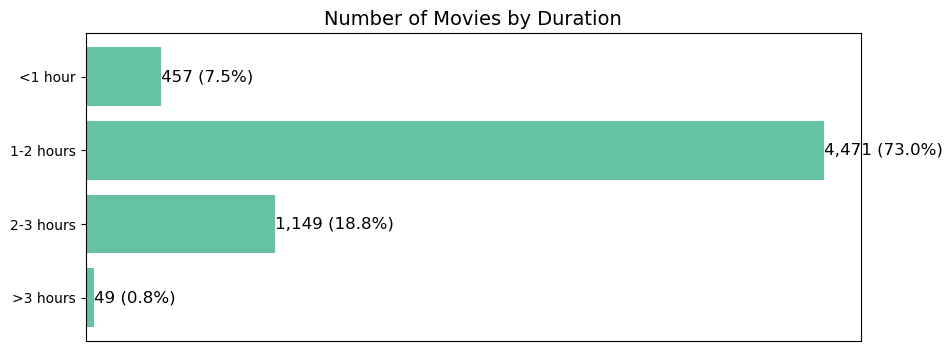

In [162]:
duration_order = ['<1 hour', '1-2 hours', '2-3 hours', '>3 hours']

duration_counts = movies['duration_group'].value_counts().loc[duration_order]

total_movies = duration_counts.sum()

plt.figure(figsize=(10, 4))
colors = sns.color_palette("Set2")

positions = range(len(duration_counts))
bars = plt.barh(positions, duration_counts.values[::-1], color=colors[0])

plt.xlabel('')
plt.title('Number of Movies by Duration', size=14)

for bar, count in zip(bars, duration_counts.values[::-1]):
    percentage = (count / total_movies) * 100
    plt.text(count, bar.get_y() + bar.get_height() / 2, f'{count:,} ({percentage:.1f}%)', va='center', fontsize=12, color='black')

plt.yticks(positions, duration_order[::-1])
# Show the chart
plt.grid(False)
plt.xticks([])
plt.show()


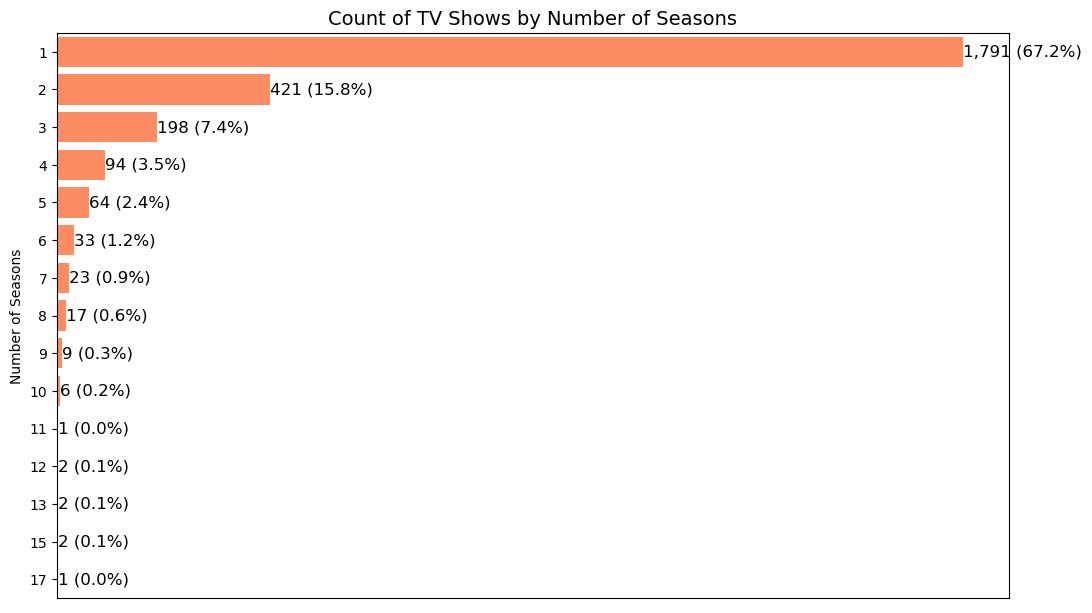

In [163]:
num_seasons_counts = shows['num_seasons'].value_counts().sort_index(ascending=False)
shows
total_shows = num_seasons_counts.sum()

plt.figure(figsize=(10, 6))

plt.subplot(1, 1, 1)
plt.tight_layout(pad=0.2)
colors = sns.color_palette("Set2")

positions = range(len(num_seasons_counts))
plt.barh(positions, num_seasons_counts, color=colors[1])

plt.ylabel('Number of Seasons')
plt.title('Count of TV Shows by Number of Seasons', size = 14)

plt.gca().invert_yaxis()

for i, count in enumerate(num_seasons_counts):
    percentage = (count / total_shows) * 100
    plt.text(count, i, f'{count:,} ({percentage:.1f}%)', va='center', fontsize=12, color='black')

plt.xticks([])
plt.yticks(positions, num_seasons_counts.index)
plt.ylim(min(positions) - 0.5, max(positions) + 0.5)

plt.grid(False)
plt.show()